In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.ndimage import uniform_filter1d  # For smoothing

# Align data to the length of the longest seed for each experiment
def align_data(data):
    max_length = max(len(seed_data) for seed_data in data)
    aligned_data = []
    for seed_data in data:
        if len(seed_data) < max_length:
            # Repeat the last value to match the length of the longest seed
            aligned_data.append(np.pad(seed_data, (0, max_length - len(seed_data)), mode='edge'))
        else:
            aligned_data.append(seed_data)
    return np.array(aligned_data)

# Compute mean and standard error for each experiment
def compute_stats(data):
    mean = np.mean(data, axis=0)
    std_error = sem(data, axis=0)
    return mean, std_error

def find_closest_index_np(sorted_array, x):
    sorted_array = np.asarray(sorted_array)
    idx = np.searchsorted(sorted_array, x, side="left")
    
    if idx > 0 and (idx == len(sorted_array) or 
                    np.abs(x - sorted_array[idx-1]) <= np.abs(x - sorted_array[idx])):
        return idx - 1
    else:
        return idx

# Smoothing function using a moving average
def smooth_data(data, window_size=10):
    """Apply a moving average to smooth the data."""
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Plotting function
def plot_results(experiments, titles, stats, steps_stats, markers, markevery, ylabel, title, loc, filename, window_size=10):
    plt.figure(figsize=(8, 5))
    for i, exp in enumerate(experiments):
        mean, std_error = stats[exp]
        step_mean, _ = steps_stats[exp]  # Use step numbers for the x-axis
        step_mean = np.round(step_mean).astype(int)
        
        # Smooth the mean and std_error
        smoothed_mean = smooth_data(mean, window_size)
        smoothed_std_error = smooth_data(std_error, window_size)

        k100 = find_closest_index_np(step_mean, 100000)
        k50 = find_closest_index_np(step_mean, 50000)
        
        marker_indices = [int(find_closest_index_np(step_mean, k)) for k in range(0, step_mean[-1], markevery)]

        print(f'{exp}: at {step_mean[k50]}: {smoothed_mean[k50]}, at {step_mean[k100]}: {smoothed_mean[k100]}, max:{max(smoothed_mean)}')
        
        plt.plot(step_mean, smoothed_mean, label=titles[i], marker=markers[i], markevery=marker_indices, markersize=10)
        plt.fill_between(step_mean, smoothed_mean - smoothed_std_error, smoothed_mean + smoothed_std_error, alpha=0.2)
    plt.xlabel('Training Steps')
    plt.ticklabel_format(axis='x', style='sci', scilimits=(3,3), useMathText=True)
    plt.margins(x=0.01)
    plt.ylabel(ylabel)
    # plt.title(title)
    # plt.legend(loc=loc, bbox_to_anchor=(-0.01, 1.02), ncol=1, framealpha=0.5)
    if loc is not None: plt.legend(loc=loc, ncol=1, framealpha=0.5)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename+".png")
    plt.savefig(filename+".pdf",bbox_inches='tight',pad_inches=0,dpi=300)
    plt.show()

PPO_AEGIS_ALT1_1E: at 50003: 0.8605399999999996, at 100000: 0.8843950000000014, max:0.8855200000000005
PPO_AEGIS_ALT1_1E_dept: at 50004: 0.3930650000000002, at 100000: 0.704799999999999, max:0.7409749999999993
PPO_AEGIS_LMDP+PPO: at 49969: 0.30400499999999997, at 100000: 0.6272, max:0.6373700000000011
PPO_AEGIS_INV_ALT4_1E: at 49993: 0.683935, at 100000: 0.8350300000000048, max:0.8507800000000005
PPO_AEGIS_ALT4_1E_dept: at 49962: 0.08292499999999996, at 100001: 0.27302499999999996, max:0.3078200000000001
PPO_AEGIS_ALT10_1E_dept: at 50001: 0.016035, at 97965: 0.028159999999999814, max:0.11156499999999976


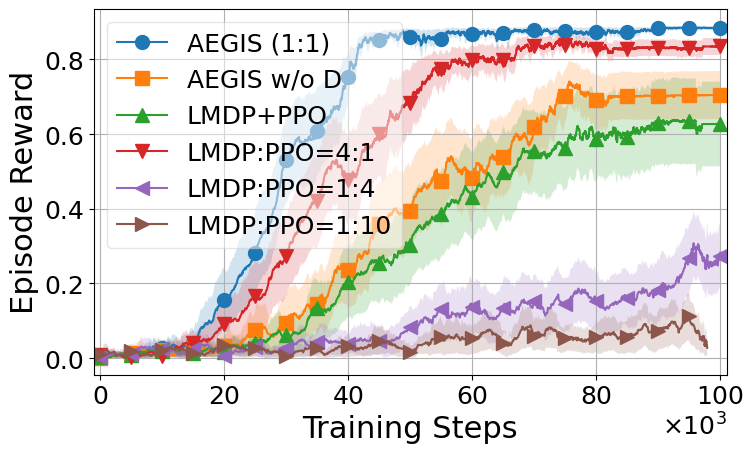

In [4]:
# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/Empty-8x8-v0"

# experiments =  ["PPO_AEGIS_ALT1_1E", 
#                 "PPO_AEGIS_ALT1_1E_dept", 
#                 "PPO_AEGIS_INV_ALT4_1E",
#                 "PPO_AEGIS_ALT1_4E_dept",
#                 "PPO_AEGIS_ALT4_1E_dept", 
#                 "PPO_AEGIS_ALT4_4E_dept",
#                 "PPO_AEGIS_ALT10_1E_dept", 
#                 "PPO_AEGIS_ALT10_4E_dept"
#                 ]

# titles =  ["AEGIS",
#             "AEGIS w/o D",  
#             "1e LMDP:PPO=4:1",
#             "4e LMDP:PPO=1:1", 
#             "1e LMDP:PPO=1:4",
#             "4e LMDP:PPO=1:4", 
#             "1e LMDP:PPO=1:10",
#             "4e LMDP:PPO=1:10"
#             ]

experiments =  ["PPO_AEGIS_ALT1_1E", 
                "PPO_AEGIS_ALT1_1E_dept", 
                "PPO_AEGIS_LMDP+PPO",
                "PPO_AEGIS_INV_ALT4_1E",
                "PPO_AEGIS_ALT4_1E_dept", 
                "PPO_AEGIS_ALT10_1E_dept",
                ]

titles =  ["AEGIS (1:1)",
            "AEGIS w/o D",
            "LMDP+PPO",  
            "LMDP:PPO=4:1",
            "LMDP:PPO=1:4",
            "LMDP:PPO=1:10",
            ]

markers = ['o', 's',  '^', 'v', '<', '>', 'D', 'X', 'P', 'p']
# Define the number of seeds
num_seeds = 10

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for exp in experiments:
    for seed in range(1, num_seeds + 1):
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}
    
episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

plt.rcParams.update({
    'font.size': 22,           # Default text size
    'axes.labelsize': 22,      # Axis labels size
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 18,     # Legend text size
})

# Plot episode rewards
plot_results(experiments, titles, episode_rewards_stats, steps_stats, markers, 5000,
             'Episode Reward', 'Ablation study on update Frequence, Epochs, and use of buffer D', loc='upper left',
             filename="aegis_components_ablation", window_size=20)

PPO_AEGIS_ALT1_1E: at 50003: 0.8605399999999996, at 100000: 0.8843950000000014, max:0.8855200000000005
PPO_AEGIS_Buffer_64: at 50006: 0.515175, at 100000: 0.8019999999999978, max:0.8416450000000009
PPO_AEGIS_Buffer_128: at 49990: 0.47850500000000046, at 100001: 0.8019999999999976, max:0.8328250000000017
PPO_AEGIS_Buffer_512: at 49986: 0.5809100000000001, at 100000: 0.6892100000000003, max:0.6897499999999999
PPO_AEGIS_Buffer_1024: at 50003: 0.34050499999999995, at 100000: 0.48299999999999726, max:0.5332749999999994


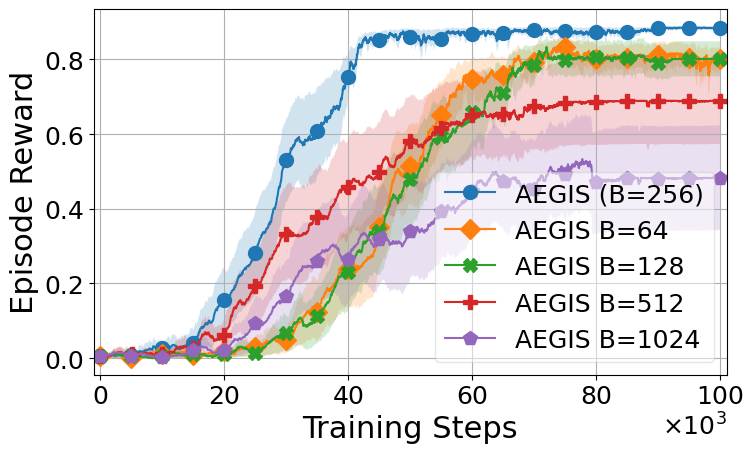

In [5]:
# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/Empty-8x8-v0"

experiments =  ["PPO_AEGIS_ALT1_1E", 
                "PPO_AEGIS_Buffer_64",
                "PPO_AEGIS_Buffer_128",
                "PPO_AEGIS_Buffer_512",
                "PPO_AEGIS_Buffer_1024",
                ]

titles =  ["AEGIS (B=256)",
           "AEGIS B=64",
           "AEGIS B=128",
           "AEGIS B=512",
           "AEGIS B=1024",
           ]

markers = ['o', 'D', 'X', 'P', 'p']
# Define the number of seeds
num_seeds = 10

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for exp in experiments:
    for seed in range(1, num_seeds + 1):
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}
    
episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

plt.rcParams.update({
    'font.size': 22,           # Default text size
    'axes.labelsize': 22,      # Axis labels size
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 18,     # Legend text size
})

# Plot episode rewards
plot_results(experiments, titles, episode_rewards_stats, steps_stats, markers, 5000,
             'Episode Reward', 'Ablation study on buffer size B', loc='lower right',
             filename="aegis_buffer_ablation", window_size=20)

PPO_AEGIS_ALT1_1E: at 50003: 0.8605399999999996, at 100000: 0.8843950000000014, max:0.8855200000000005
PPO_AEGIS_Buffer_256_75_25: at 50003: 0.2835850000000001, at 100000: 0.6841000000000007, max:0.7200100000000008
PPO_AEGIS_25_75_Buffer_256: at 50004: 0.6351150000000002, at 100000: 0.7059150000000003, max:0.7364249999999996
PPO_AEGIS_100_0: at 49988: 0.3577650000000001, at 100000: 0.5885000000000009, max:0.6256699999999991
PPO_AEGIS_0_100: at 49994: 0.3718699999999996, at 99999: 0.5021799999999991, max:0.5065449999999995


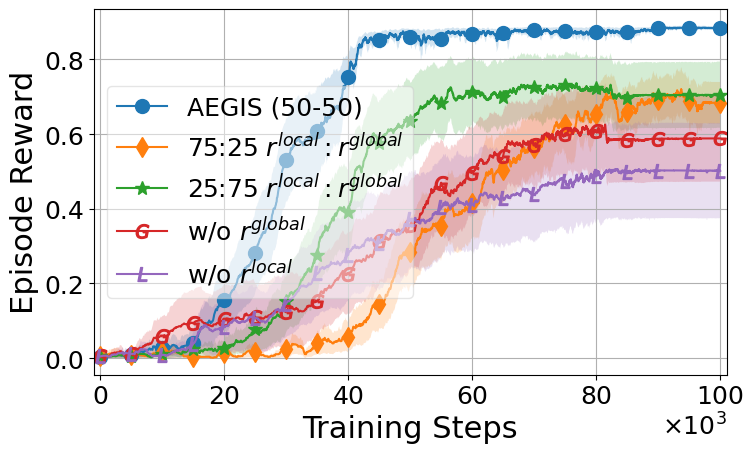

In [13]:
# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/Empty-8x8-v0"

experiments =  ["PPO_AEGIS_ALT1_1E", 
                "PPO_AEGIS_Buffer_256_75_25",
                "PPO_AEGIS_25_75_Buffer_256",
                "PPO_AEGIS_100_0",
                "PPO_AEGIS_0_100",
                ]

titles =  ["AEGIS (50-50)",
           r"75:25 $r^{local}:r^{global}$",
           r"25:75 $r^{local}:r^{global}$",
           r"w/o $r^{global}$",
           r"w/o $r^{local}$",
           ]

markers = ['o', 'd', '*', '$G$', '$L$']
# Define the number of seeds
num_seeds = 10

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for exp in experiments:
    for seed in range(1, num_seeds + 1):
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}
    
episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

plt.rcParams.update({
    'font.size': 22,           # Default text size
    'axes.labelsize': 22,      # Axis labels size
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 18,     # Legend text size
})

# Plot episode rewards
plot_results(experiments, titles, episode_rewards_stats, steps_stats, markers, 5000,
             'Episode Reward', 'Ablation study on buffer size B and intrinsic reward weights', loc='best',
             filename="aegis_reward_ablation", window_size=20)

PPO_VanillaGPU: at 50015: 0.5421699999999994, at 100000: 0.6911999999999975, max:0.6945749999999993
PPO_LMDP_Offline_5E5: at 50004: 0.8607700000000003, at 100000: 0.8668000000000028, max:0.8836300000000025
PPO_AE_Offline_CNN_Freeze: at 50018: 0.17312500000000014, at 100000: 0.4541100000000003, max:0.45420000000000044
PPO_AEGIS_ALT1_1E: at 50003: 0.8605399999999996, at 100000: 0.8843950000000014, max:0.8855200000000005


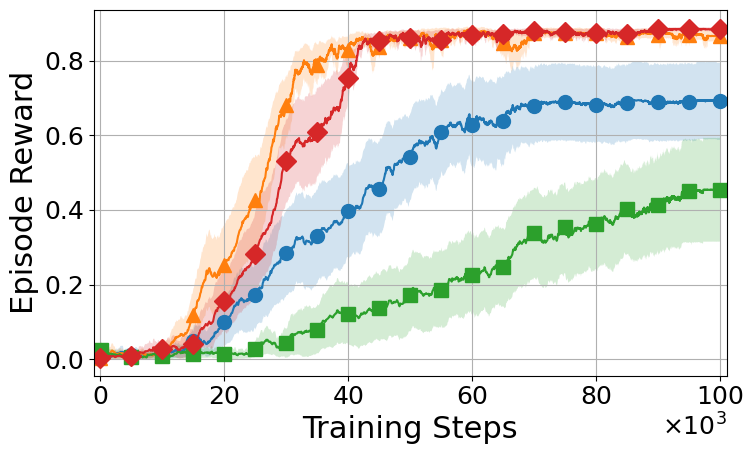

In [32]:
# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/Empty-8x8-v0"

experiments =  ["PPO_VanillaGPU",
                "PPO_LMDP_Offline_5E5", 
                "PPO_AE_Offline_CNN_Freeze",
                "PPO_AEGIS_ALT1_1E",
                ]

titles =  ["Vanilla PPO",
           "LMDP Offline",
           "AE Offline",
           "AEGIS",
           ]

markers = ['o', '^', 's', 'D', 'h', 'X', 'P', 'p']
# Define the number of seeds
num_seeds = 10

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for exp in experiments:
    for seed in range(1, num_seeds + 1):
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}
    
episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

plt.rcParams.update({
    'font.size': 22,           # Default text size
    'axes.labelsize': 22,      # Axis labels size
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 18,     # Legend text size
})

# Plot episode rewards
plot_results(experiments, titles, episode_rewards_stats, steps_stats, markers, 5000,
             'Episode Reward', 'Ablation study on buffer size B and intrinsic reward weights', loc=None,
             filename="aegis_comparative_reward", window_size=20)

PPO_Vanilla: at 49999: 0.10733500000000011, at 99995: 0.5883324999999994, max:0.6716300000000004
PPO_LMDP_Offline: at 50012: 0.3562075000000001, at 100004: 0.7496925000000009, max:0.8422024999999957
PPO_AE_Offline: at 49990: 2.2551405187698493e-18, at 100028: 0.25369, max:0.6219349999999998
PPO_AEGIS: at 50013: 0.2788100000000001, at 99999: 0.8893899999999993, max:0.893484999999999


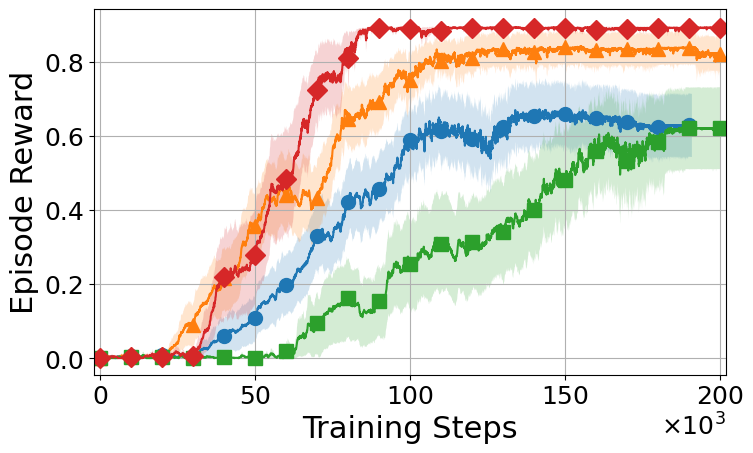

In [49]:
# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/DistShift2-v0"

experiments =  ["PPO_Vanilla",
                "PPO_LMDP_Offline",
                "PPO_AE_Offline",
                "PPO_AEGIS",
                ]

titles =  ["Vanilla PPO",
           "LMDP Offline",
           "AE Offline",
           "AEGIS",
           ]

markers = ['o', '^', 's', 'D', 'h', 'X', 'P', 'p']
# Define the number of seeds
num_seeds = [20, 20, 10, 10]  # Different number of seeds for each experiment

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for i, exp in enumerate(experiments):
    for seed in range(1, num_seeds[i] + 1):
        # print(f"Reading {exp} with seed {seed}")
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}
    
episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

plt.rcParams.update({
    'font.size': 22,           # Default text size
    'axes.labelsize': 22,      # Axis labels size
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 18,     # Legend text size
})

# Plot episode rewards
plot_results(experiments, titles, episode_rewards_stats, steps_stats, markers, 10000,
             'Episode Reward', 'Ablation study on buffer size B and intrinsic reward weights', loc=None,
             filename="aegis_comparative_reward_2", window_size=20)

PPO_Vanilla: at 50034: 0.006047999999999998, at 100009: 0.055344, max:0.4207940000000002
PPO_LMDP_Offline: at 50031: 0.060930000000000026, at 100016: 0.42233000000000026, max:0.5758939999999991
PPO_AE_Offline: at 49952: 0.0038459999999999987, at 99976: 0.012426000000000001, max:0.18253799999999995
PPO_AEGIS_Buffer_256: at 50022: 0.02720999999999999, at 99980: 0.39317199999999985, max:0.7003479999999996


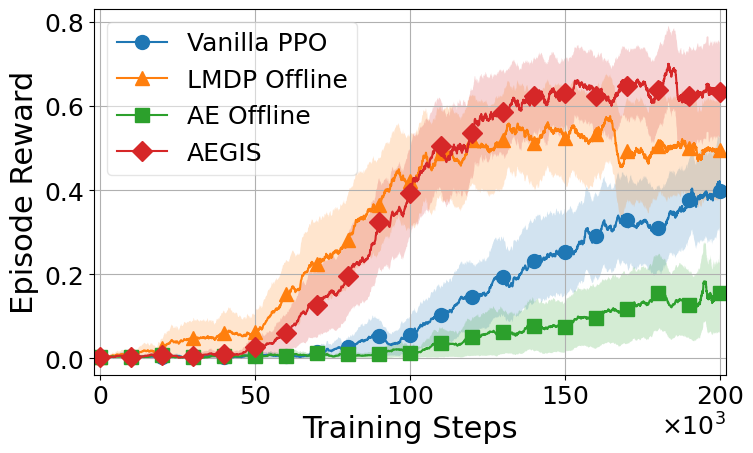

In [3]:
# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/DoorKey-5x5-v0"

experiments =  ["PPO_Vanilla",
                "PPO_LMDP_Offline",
                "PPO_AE_Offline",
                "PPO_AEGIS_Buffer_256",
                ]

titles =  ["Vanilla PPO",
           "LMDP Offline",
           "AE Offline",
           "AEGIS",
           ]

markers = ['o', '^', 's', 'D', 'h', 'X', 'P', 'p']
# Define the number of seeds
num_seeds = [10, 10, 10, 10]  # Different number of seeds for each experiment

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for i, exp in enumerate(experiments):
    for seed in range(1, num_seeds[i] + 1):
        # print(f"Reading {exp} with seed {seed}")
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            # print(f"Reading {file_path}")
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}
    
episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

plt.rcParams.update({
    'font.size': 22,           # Default text size
    'axes.labelsize': 22,      # Axis labels size
    'xtick.labelsize': 18,     # X-axis tick labels
    'ytick.labelsize': 18,     # Y-axis tick labels
    'legend.fontsize': 18,     # Legend text size
})

# Plot episode rewards
plot_results(experiments, titles, episode_rewards_stats, steps_stats, markers, 10000,
             'Episode Reward', 'Ablation study on buffer size B and intrinsic reward weights', loc='upper left',
             filename="aegis_comparative_reward_3", window_size=50)